In [1]:
from matplotlib.patches import Ellipse
from scipy import stats
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.optimize as optimize

from artificialdata import init
from artificialdata import obs
from artificialdata import odes
from artificialdata import p_vec
from artificialdata import time_vec
from artificialdata import v_in

%matplotlib inline
np.random.seed(42)

In [2]:
Vmax_actual, Km_actual = p_vec

In [3]:
def error(p, t, init, v_in):
    return (odeint(odes, init, t, args=(p, v_in)) - obs).flatten()

# Importing results from pymc simulation

In [4]:
mcmc = pd.read_pickle('v_input_09.pkl')
mcmc_up = pd.read_pickle('v_input_14p5.pkl')
mcmc_dw = pd.read_pickle('v_input_04p5.pkl')

In [5]:
fit_cols = ['Vmax', 'Km'] + list(time_vec) + ['ss']
fit_df = pd.DataFrame(columns=fit_cols)
for i in range(mcmc.shape[0]):
    p = mcmc[['Vmax', 'Km']].iloc[i].values
    xt = odeint(odes, init, time_vec, args=(p, v_in)).ravel()
    ss = sum((xt - obs)**2)
    l = list(p) + list(xt) + [ss]
    fit_df = fit_df.append(pd.DataFrame([l], columns=fit_cols), ignore_index=True)

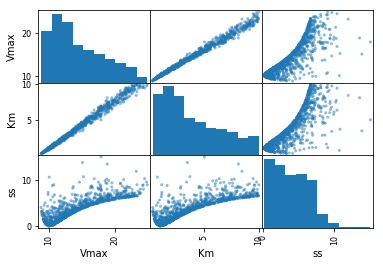

In [6]:
pd.plotting.scatter_matrix(fit_df[['Vmax', 'Km', 'ss']]);

In [7]:
#fit_df = fit_df[fit_df['ss'] < fit_df['ss'].quantile(0.25)]

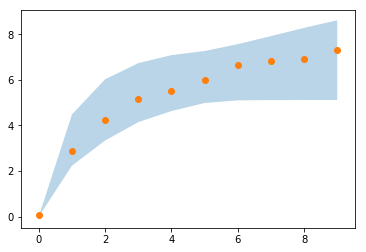

In [8]:
fit_max = fit_df[time_vec].max(axis=0)
fit_min = fit_df[time_vec].min(axis=0)
plt.fill_between(time_vec, fit_min, fit_max, alpha=0.3)
plt.scatter(time_vec, obs);

# Predicting new conditions

In [9]:
half_v_in_df = pd.DataFrame(columns=fit_cols)
for i in range(mcmc.shape[0]):
    p = mcmc[['Vmax', 'Km']].iloc[i].values
    xt = odeint(odes, init, time_vec, args=(p, v_in*0.5)).ravel()
    ss = sum((xt - obs)**2)
    l = list(p) + list(xt) + [ss]
    half_v_in_df = half_v_in_df.append(pd.DataFrame([l], columns=fit_cols), ignore_index=True)
    
twice_v_in_df = pd.DataFrame(columns=fit_cols)
for i in range(mcmc.shape[0]):
    p = mcmc[['Vmax', 'Km']].iloc[i].values
    xt = odeint(odes, init, time_vec, args=(p, v_in*1.5)).ravel()
    ss = sum((xt - obs)**2)
    l = list(p) + list(xt) + [ss]
    twice_v_in_df = twice_v_in_df.append(pd.DataFrame([l], columns=fit_cols), ignore_index=True)

half_max = half_v_in_df[time_vec].max(axis=0)
half_min = half_v_in_df[time_vec].min(axis=0)

twice_max = twice_v_in_df[time_vec].max(axis=0)
twice_min = twice_v_in_df[time_vec].min(axis=0)

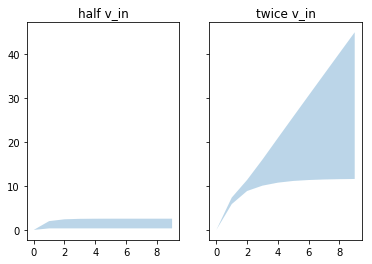

In [10]:
fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].fill_between(time_vec, half_min, half_max, alpha=0.3)
ax[0].set_title('half v_in')
ax[1].fill_between(time_vec, twice_min, twice_max, alpha=0.3)
ax[1].set_title('twice v_in');
# It seems that increasing v_in would inform more about better about the true parameters

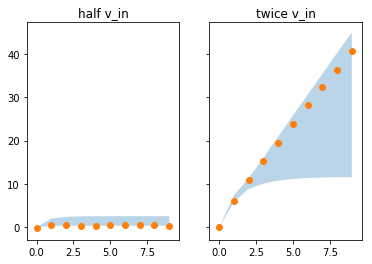

In [11]:
new_obs_up = (odeint(odes, init, time_vec, args=(p, v_in*1.5)).ravel() +
              np.random.randn(xt.flatten().shape[0])*0.15)
new_obs_down = (odeint(odes, init, time_vec, args=(p, v_in*0.5)).ravel() +
                np.random.randn(xt.flatten().shape[0])*0.15)

fig, ax = plt.subplots(ncols=2, sharey=True)
ax[0].fill_between(time_vec, half_min, half_max, alpha=0.3)
ax[0].scatter(time_vec, new_obs_down)
ax[0].set_title('half v_in')
ax[1].fill_between(time_vec, twice_min, twice_max, alpha=0.3)
ax[1].scatter(time_vec, new_obs_up)
ax[1].set_title('twice v_in');

# Compare estimated paramter spaces

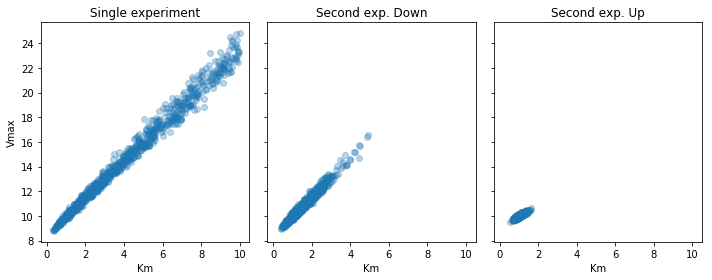

In [12]:
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(10,4))
ax[0].scatter(mcmc['Km'], mcmc['Vmax'], alpha=0.3)
ax[0].set_ylabel('Vmax')
ax[0].set_title('Single experiment')
ax[1].scatter(mcmc_dw['Km'], mcmc_dw['Vmax'], alpha=0.3)
ax[1].set_title('Second exp. Down')
ax[2].scatter(mcmc_up['Km'], mcmc_up['Vmax'], alpha=0.3)
ax[2].set_title('Second exp. Up')
for axis in ax:
    axis.set_xlabel('Km')
fig.tight_layout();